In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [10]:
# Laste poll-of-polls data
df = pd.read_csv("../data/pollofpolls_mai.csv", sep=";")

In [11]:
df

,Mnd,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
0,Mai-25,31.6,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8
1,April-25,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9
2,Mars-25,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4
3,Februar-25,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
4,Januar-25,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
...,...,...,...,...,...,...,...,...,...,...,...
204,Mai-08,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
205,April-08,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
206,Mars-08,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
207,Februar-08,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0


In [12]:
###for å kunne konvertere til dato datatype
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [13]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [14]:
df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
2025-02-28,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4


In [15]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [16]:
df_diff

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-02-29,-0.3,0.1,1.3,-0.7,-0.2,-0.1,0.1,0.0,0.0,0.0
2008-03-31,-0.3,0.8,0.0,0.3,-0.3,-0.2,-0.3,0.0,-0.2,0.0
2008-04-30,0.3,-1.2,0.2,-0.5,-0.1,0.9,0.5,0.0,0.1,0.0
2008-05-31,-0.1,0.9,0.5,0.2,0.2,-0.8,-0.6,0.0,0.2,0.0
2008-06-30,-2.9,-0.2,3.0,0.2,-0.4,-0.1,-0.3,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,1.9,1.0,-1.3,-1.4,0.6,-0.5,-0.8,0.2,-0.2,0.4
2025-02-28,5.7,-3.8,0.5,-0.6,0.7,-0.4,-0.3,-0.9,-0.2,-0.7
2025-03-31,3.3,0.4,-1.9,-0.2,-1.7,0.1,0.1,0.3,-0.8,0.2


In [17]:
model = VAR(df_diff)  
model_fitted = model.fit(maxlags=4,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Jun, 2025
Time:                     20:23:52
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -5.70520
Nobs:                     204.000    HQIC:                  -9.57948
Log likelihood:          -1249.08    FPE:                5.23643e-06
AIC:                     -12.2113    Det(Omega_mle):     8.73854e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -1.594625         0.445743           -3.577           0.000
L1.Hoyre          -1.638487         0.446373           -3.671           0.000
L1.Frp            -1.660229         0.447172           -3.713           0.0

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [18]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [19]:
all_fitted= model_fitted.fittedvalues

In [20]:
all_fitted

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-06-30,-0.334896,0.264020,0.053867,-0.155634,-0.098472,0.248675,-0.015657,-0.018764,-0.136979,0.023281
2008-07-31,0.354048,-0.349827,-0.164512,-0.046642,-0.471777,-0.007649,0.250621,0.103584,0.068704,0.156458
2008-08-31,-1.148934,0.121364,0.523231,-0.318203,0.856494,-0.261236,0.373863,-0.067694,0.284231,-0.285828
2008-09-30,0.235205,-0.601711,-0.299739,0.089340,-0.441477,0.476426,0.103803,0.014986,0.082721,0.195327
2008-10-31,0.034766,1.028109,-1.274837,0.373802,-0.141717,0.057626,0.260031,0.067871,-0.286536,0.114653
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,0.249430,0.777344,-0.262276,-0.422091,0.105762,-0.687645,-0.090545,0.081870,-0.187121,-0.176402
2025-02-28,0.617027,-0.683989,-0.239733,-0.000771,0.563073,-0.271214,0.449258,-0.277064,0.074484,-0.035702
2025-03-31,1.793379,-0.263995,-0.974422,-0.226867,-0.632398,0.235724,0.245095,0.134374,-0.451079,0.308694


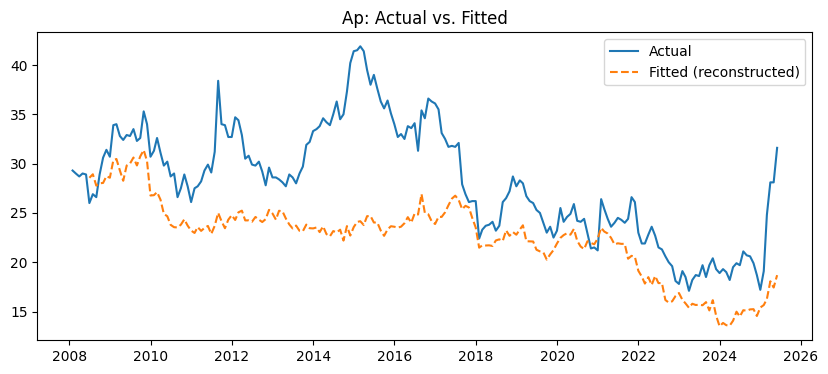

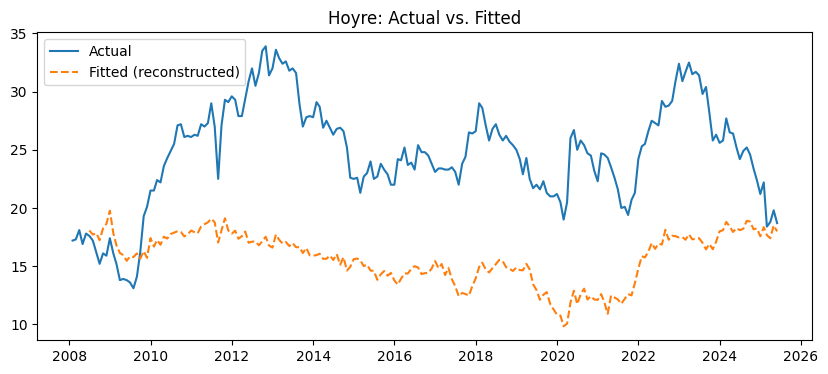

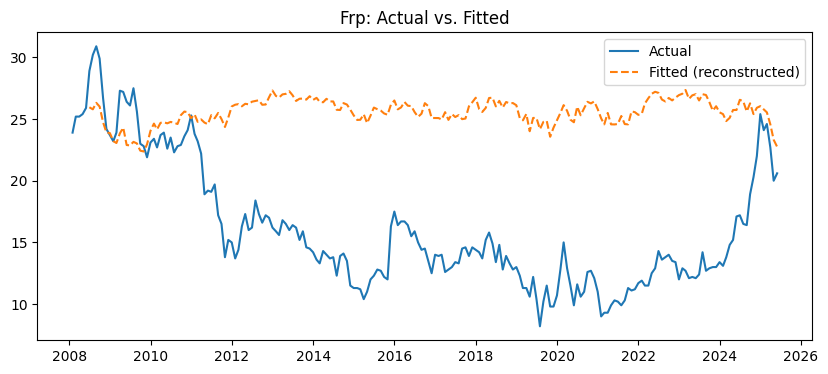

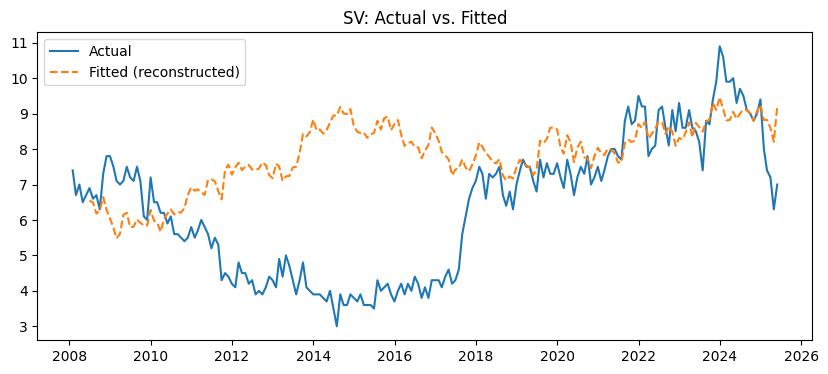

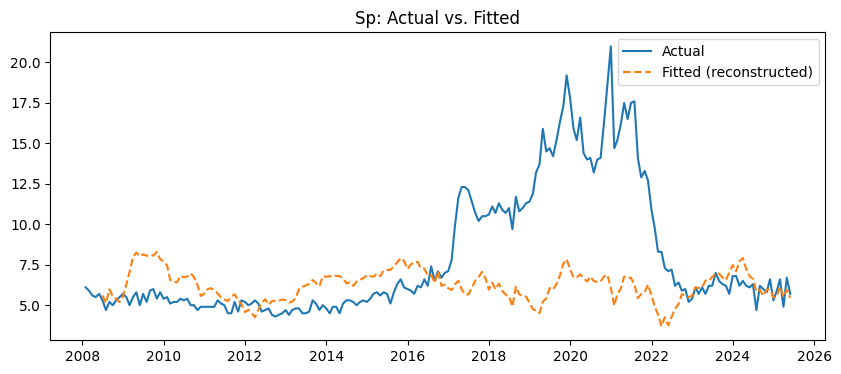

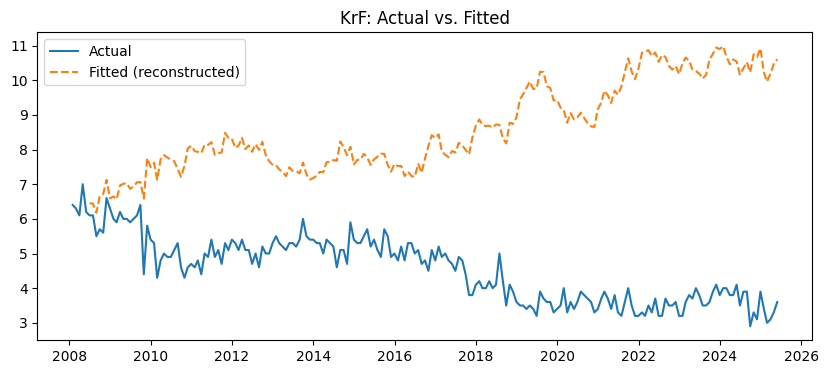

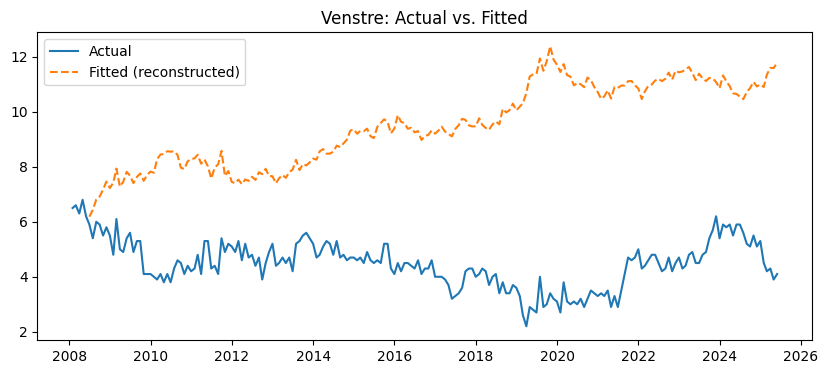

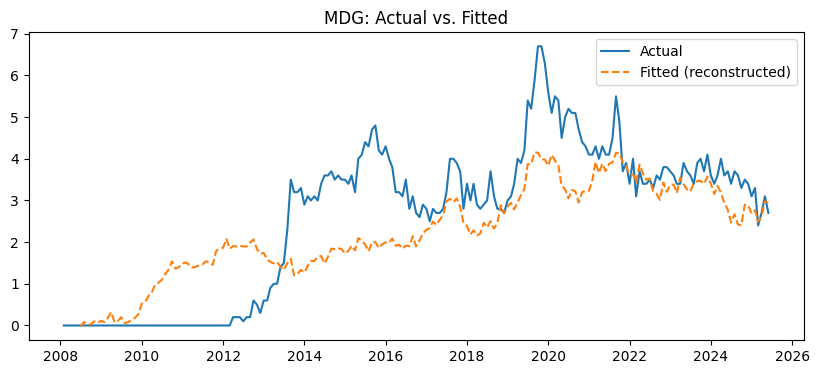

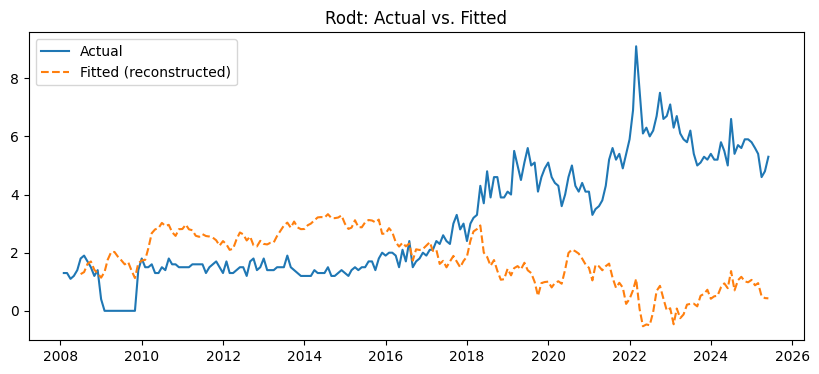

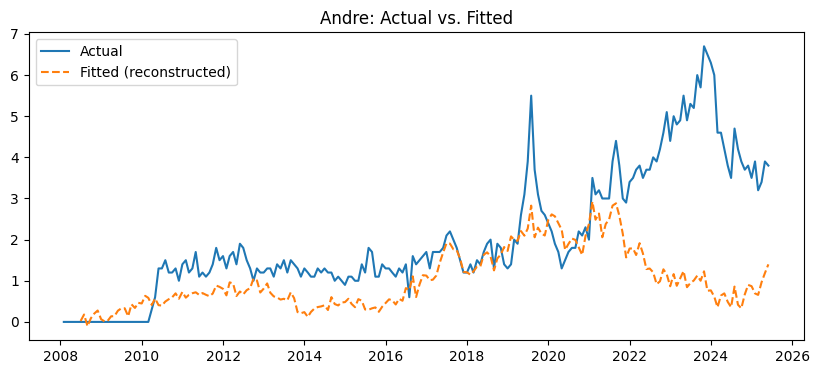

In [21]:
import matplotlib.pyplot as plt

# Number of lags used
n_lags = model_fitted.k_ar  # This will be 10 if you set maxlags=10

# 1. Get fitted differenced values and align index
fitted_diff = model_fitted.fittedvalues
fitted_diff.index = df.index[n_lags+1:]  # Shift index to match df after lag+diff

# 2. Reconstruct original values from differenced fitted values
# Start from the (n_lags)th actual row of original df
start_value = df.iloc[n_lags]  # This is the starting point for cumulative sum
fitted_orig = fitted_diff.cumsum() + start_value

# 3. Plot actual vs fitted
for col in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df[col], label='Actual')
    plt.plot(fitted_orig[col], label='Fitted (reconstructed)', linestyle='--')
    plt.title(f"{col}: Actual vs. Fitted")
    plt.legend()
    plt.show()


In [187]:
fitted_orig

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-06-30,28.602678,18.054089,25.973388,6.539324,5.593099,6.451452,6.184584,-0.025037,1.271515,0.018057
2008-07-31,29.043068,17.681440,25.853736,6.481097,5.101951,6.450186,6.435758,0.064132,1.359740,0.162508
2008-08-31,27.952282,17.787435,26.407178,6.155093,5.945400,6.193249,6.809993,-0.013271,1.657117,-0.131406
2008-09-30,28.250965,17.168945,26.140419,6.235916,5.489681,6.674367,6.914203,-0.008883,1.754189,0.055094
2008-10-31,28.195477,18.220909,24.818690,6.621828,5.368212,6.725321,7.173656,0.074056,1.447249,0.182297
...,...,...,...,...,...,...,...,...,...,...
2024-12-31,14.993533,17.681061,25.830514,9.298668,5.568492,10.888452,10.988275,2.755594,0.971065,0.926447
2025-01-31,15.498522,18.390858,25.701013,8.842289,5.616921,10.219699,10.899366,2.794797,0.841721,0.714508
2025-02-28,16.063324,17.720672,25.434146,8.848526,6.191710,9.944624,11.348290,2.526452,0.904397,0.686068


In [22]:
lags = [1, 3, 6]  # Lags you want
df_lagged = df.copy()

for col in df.columns:
    for lag in lags:
        df_lagged[f"{col}_lag{lag}"] = df[col].shift(lag)

In [23]:
#df_lagged.to_csv('lag.csv', sep=";")

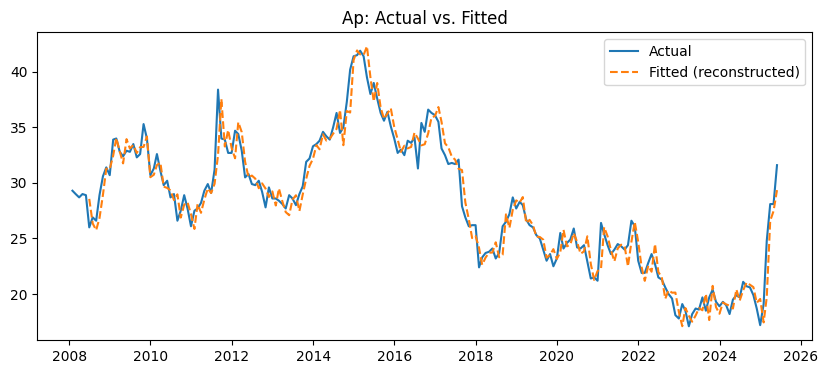

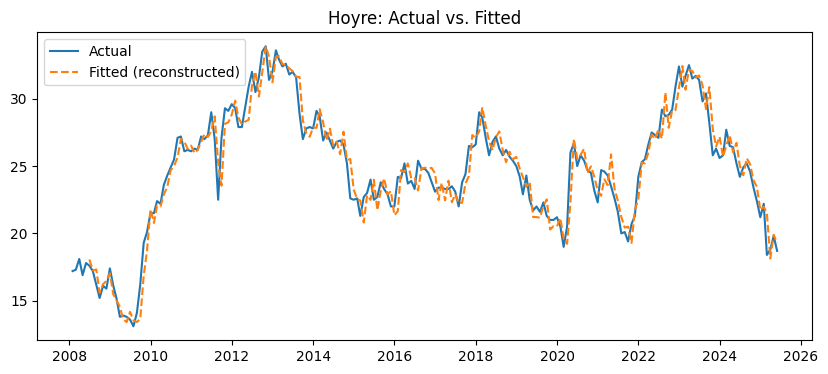

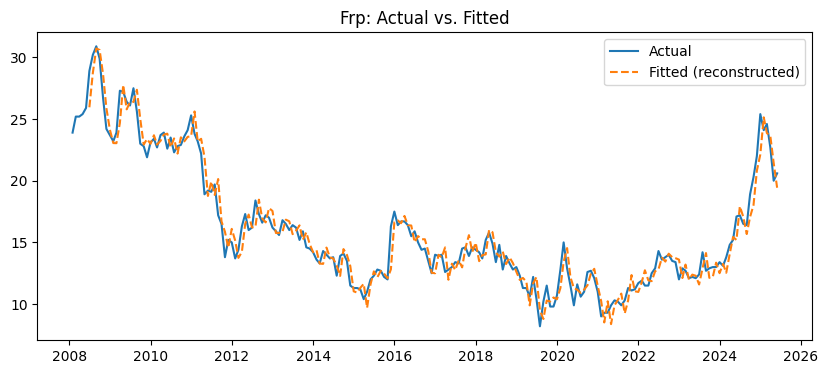

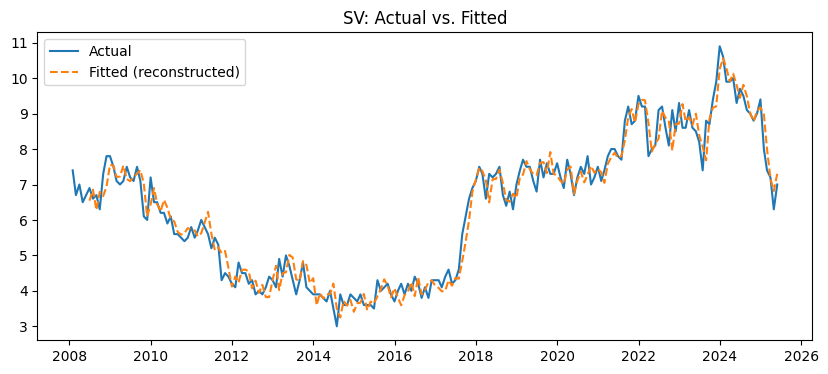

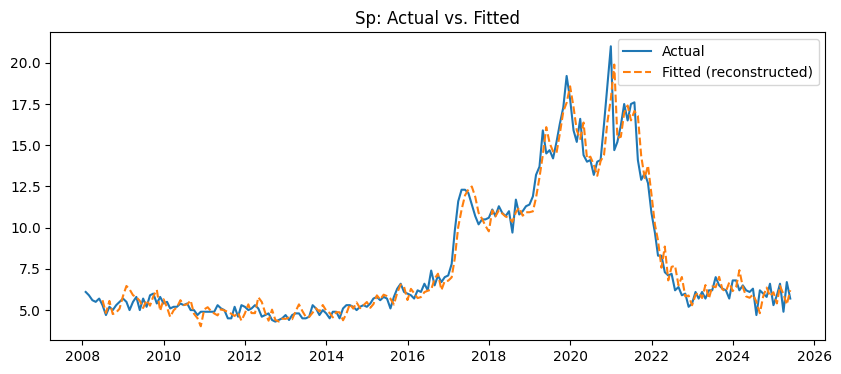

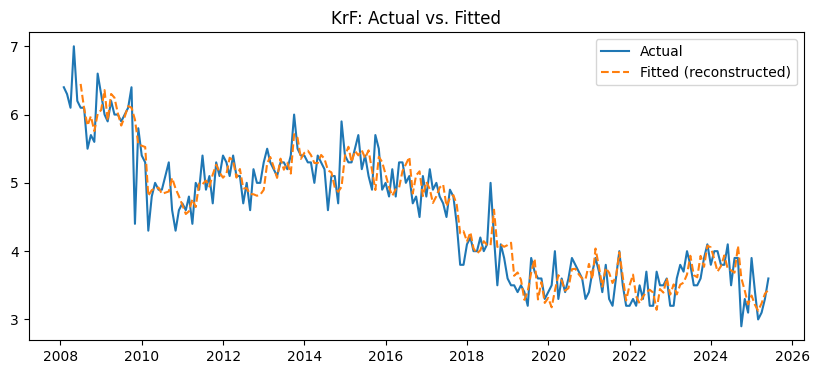

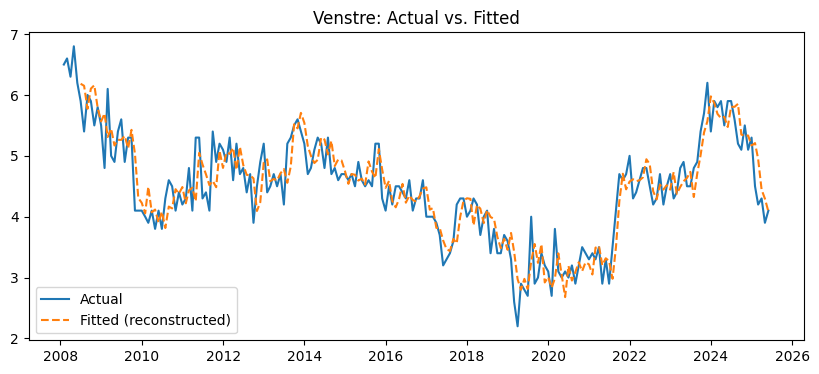

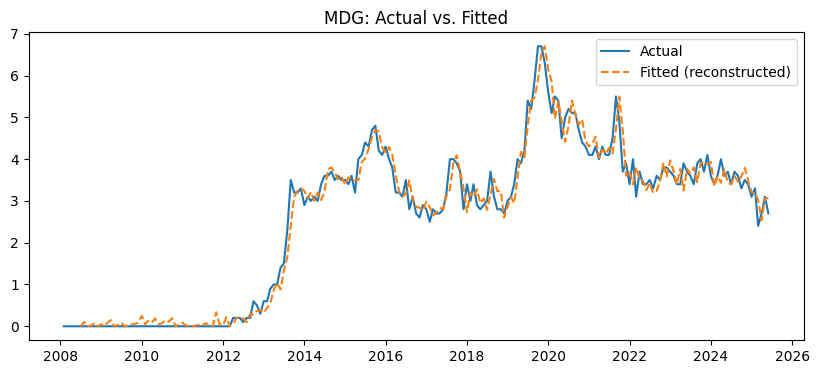

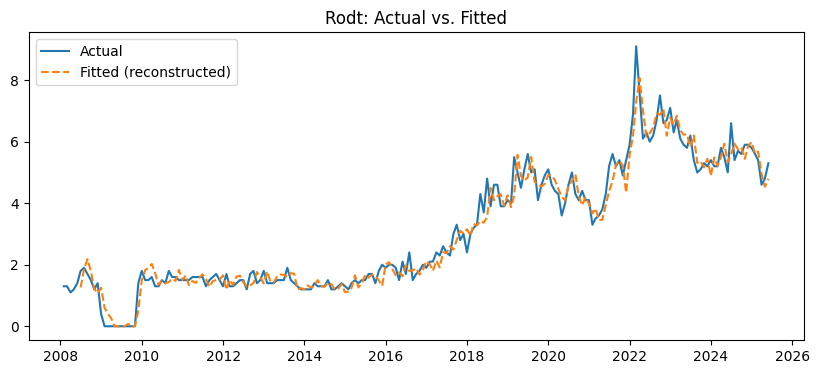

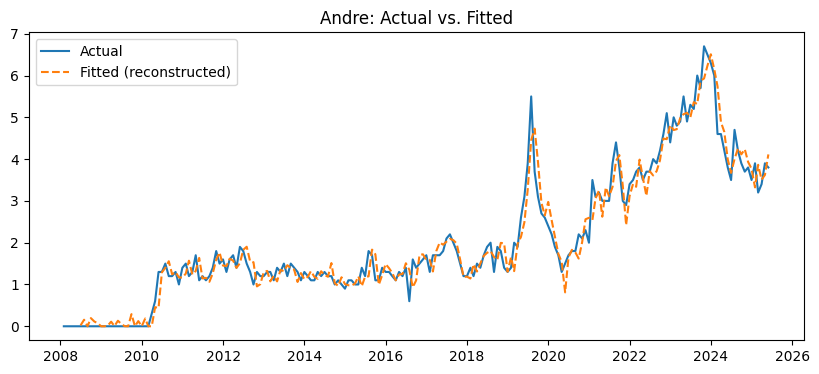

In [24]:
# Number of lags used
n_lags = model_fitted.k_ar  # e.g., 10 if you set maxlags=10

# 1. Get fitted differenced values and align index
fitted_diff = model_fitted.fittedvalues
fitted_diff.index = df.index[n_lags+1:]  # Align fitted_diff index with df

# 2. Reconstruct original values from differenced fitted values
# Use actual value from t-1 plus predicted diff at t
fitted_orig = pd.DataFrame(index=fitted_diff.index, columns=df.columns)

for t in fitted_diff.index:
    prev_time = df.index[df.index.get_loc(t) - 1]  # t-1
    fitted_orig.loc[t] = (df.loc[prev_time] + fitted_diff.loc[t]).clip(lower=0)

# 3. Plot actual vs fitted
for col in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df[col], label='Actual')
    plt.plot(fitted_orig[col], label='Fitted (reconstructed)', linestyle='--')
    plt.title(f"{col}: Actual vs. Fitted")
    plt.legend()
    plt.show()


In [25]:
fitted_orig

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-06-30,28.565104,18.06402,25.953867,6.544366,5.601528,6.448675,6.184343,0.0,1.263021,0.023281
2008-07-31,26.354048,17.250173,28.735488,6.853358,4.828223,6.092351,6.150621,0.103584,1.868704,0.156458
2008-08-31,25.751066,17.321364,30.723231,6.281797,5.556494,5.838764,5.773863,0.0,2.184231,0.0
2008-09-30,26.835205,15.598289,30.600261,6.78934,4.758523,5.976426,6.103803,0.014986,1.782721,0.195327
2008-10-31,28.934766,16.228109,28.625163,6.673802,4.858283,5.757626,6.160031,0.067871,1.213464,0.114653
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,17.44943,21.977344,25.137724,8.977909,5.405762,3.212355,5.209455,3.18187,5.612879,3.323598
2025-02-28,19.717027,21.516011,23.860267,7.999229,6.463073,3.128786,4.949258,3.022936,5.674484,3.864298
2025-03-31,26.593379,18.136005,23.625578,7.173133,5.967602,3.235724,4.445095,2.534374,4.948921,3.508694


In [198]:
fitted_orig.to_csv('fitted_orig.csv',sep=";")